In [57]:
import torch
import torch.nn as nn 
import numpy as np

In [58]:
import torch
from torchvision import transforms
from PIL import Image

# Definir la ruta al archivo de imagen
image_path = 'img4.jpg'

# Cargar la imagen usando PIL
image = Image.open(image_path).convert('L')  # Usar 'L' para convertir a escala de grises

# Definir transformaciones para ajustar el tamaño de la imagen y convertirla en un tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Cambia el tamaño de la imagen a 256x256 píxeles
    transforms.ToTensor()           # Convierte la imagen PIL en un tensor de PyTorch
])

# Aplicar la transformación a la imagen
tensor_image = transform(image)

# Si necesitas que el tensor tenga una dimensión de lote, puedes usar unsqueeze
tensor_image = tensor_image.unsqueeze(0)

# Ahora tensor_image está listo para ser utilizado en tu modelo o cualquier otra operación
print(tensor_image.shape)  # Debería mostrar algo como torch.Size([1, 1, 256, 256])



torch.Size([1, 1, 256, 256])


In [59]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = Conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) 

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = Conv(in_channels, out_channels)
        self.up = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
        

    def forward(self, x1, x2):
        x_1 = self.conv(x1)
        x_1a = self.up(x_1)
        x = torch.cat([x_1a, x2], 1)
        
        return x
    
    

In [64]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
 
        self.conv_in = Conv(in_channels, 64)
    
        self.down_convolution_1 = DownSample(64, 128)
        self.down_convolution_2 = DownSample(128, 256)
        
        self.bottle_neck = Conv(256, 256)
        self.bottle_neck1 = Conv(256, 256)
 
        self.up_convolution_1 = UpSample(256+256, 128)
        self.up_convolution_2 = UpSample(128+128, 64)
        
        #self.conv_out = Conv(64, 2)
        
        self.out = nn.Sequential(
            nn.Conv2d(64+64, out_channels=num_classes, kernel_size=1),
            nn.Sigmoid() 
        )
        
        self.out1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=num_classes, kernel_size=1),
            nn.Sigmoid() 
        )
        

    def forward(self, x):
        
        x1 = self.conv_in(x)
        
        c1, d1 = self.down_convolution_1(x1)
        #print("p1 ", {p1.shape})
        c2, d2 = self.down_convolution_2(d1)
        
        #print("p2 ", {p2.shape})
        b = self.bottle_neck(d2)
        #print("b ", {b.shape})
        b2 = self.bottle_neck1(b)
        
        b_cat = torch.cat([b, d2], 1)
        
        
        #print("b2 ", {b2.shape})
        
        up_1 = self.up_convolution_1(b_cat, d1) 
        #print("up1 ", {up_1.shape})
        up_2 = self.up_convolution_2(up_1, x1)  
        #print("up2 ", {up_2.shape})
        logits = self.out(up_2)
 
        # Dividir logits en phi_s y phi_h
        phi_s = logits[:, 0:1, :, :]  # Primer canal para phi_s
        phi_h = logits[:, 1:2, :, :]  # Segundo canal para phi_h
 
        #img = apply_s_curve(x,phi_s, phi_h )
        
 
        return phi_s, phi_h

# Si inicializas la red así:
unet = UNet(in_channels=1, num_classes=2)  # Suponiendo que el canal de luminancia es la única entrada
x = torch.rand(1, 1, 256, 256)   # Values between -1 and 1



# Apply the operation and print the result
s, h = unet(tensor_image) 

print(s.shape)
print(h.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])


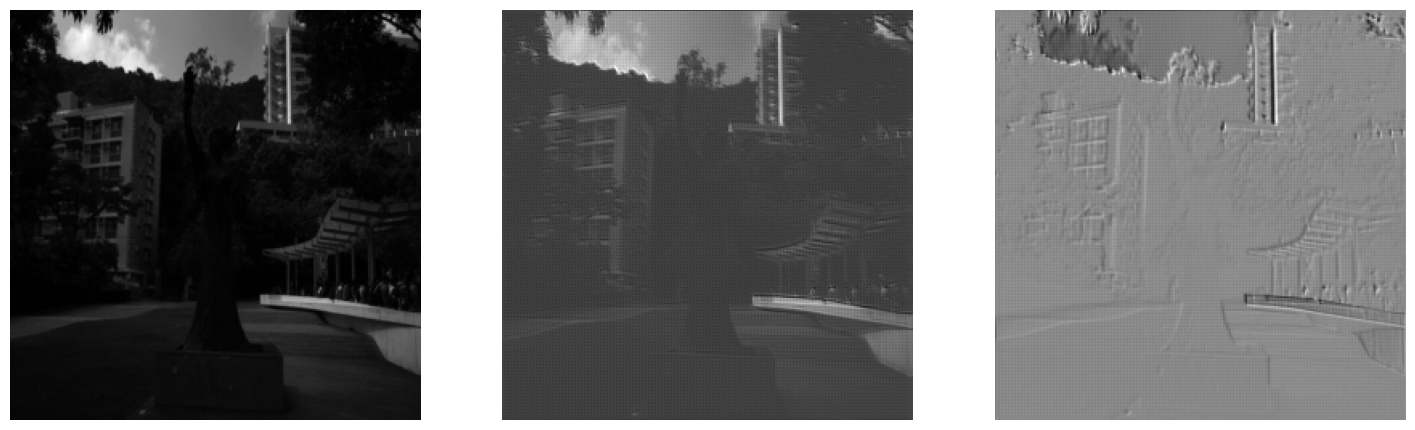

In [65]:
import torch
import matplotlib.pyplot as plt

# Supongamos que estos son tus tensores, cada uno con dimensiones [1, 1, 256, 256]
tensor1 = torch.rand(1, 1, 256, 256)
tensor2 = torch.rand(1, 1, 256, 256)
tensor3 = torch.rand(1, 1, 256, 256)

# Crear una lista de tensores para facilitar el procesamiento
tensors = [tensor_image.detach().numpy(), s.detach().numpy(), h.detach().numpy()]

# Configurar el tamaño de la figura para una buena visualización
plt.figure(figsize=(18, 6))  # Aumentar el ancho para acomodar tres imágenes

# Iterar sobre la lista de tensores para mostrar cada uno
for i, tensor in enumerate(tensors):
    image = tensor.squeeze(0).squeeze(0)  # Remover dimensiones de lote y canal
    ax = plt.subplot(1, 3, i + 1)  # 1 fila, 3 columnas, índice de imagen i+1
    ax.imshow(image, cmap='gray')
    ax.axis('off')  # Ocultar los ejes

plt.show()

